# Projeto C318

O projeto tem como intuito fazer uma anásile de um dataset fornecido neste link do [Kaggle](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?resource=download&select=diabetes.csv).  
No qual, se trata de um dataset que contém alguns dados médicos, em particular, de mulheres com pelo menos 21 anos e de ascendência indígena Pima.  
Cujo o intuito é criar um modelo de ML, capaz de prever se o paciente tem ou não diabetes.

## Importação de Bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.gaussian_process import GaussianProcessClassifier


## Análise dos dados

In [2]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
print(f"Este dataset contém os dados clínicos de {len(df)} pacientes")
print(f"Features: {df.columns.to_list()[:-1]}")
print(f"Target: {df.columns.to_list()[-1]}")
print(f"Existe valores faltantes? {df.isna().any().any()}")

Este dataset contém os dados clínicos de 768 pacientes
Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Target: Outcome
Existe valores faltantes? False


Diante dos tipos de dados apresentados, pode-se concluir que o dataset escolhido não apresenta variáveis categóricas

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Análise da Variável Target

A variável target é qualitativa(categórica), logo estamos trabalhando com um modelo de classificação.  
Na figura abaixo podemos analisar a quantidade de pacientes com(1) e sem(0) diabetes.  
É possível notar que o dataset se encontra desbalanceado.

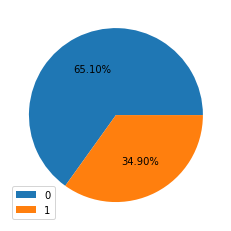

In [6]:
plt.pie(df['Outcome'].value_counts().to_list(), autopct='%.02f%%')
plt.legend(['0', '1'])
plt.show()

### Divisão dos Dados para Treino e Teste

Dado o desbalanceamento dos dados, a divisão dos dados usando o método [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do sklearn, iria inserir uma inconsistência nos dados. Podendo coletar mais amostras de uma população do que de outra. Logo, o método adequado é o [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html).

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df.Outcome):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

### Análise das Features

#### Pregnancies

Representa o número de vezes que aquela paciente ficou grávida.  
Como podemos analisar abaixo, este valor varia entre 0 e 17.  
Neste gráfico podemos analisar a proporção de pacientes com e sem diabetes, levando em consideração o número de gestações.  
Uma curiosidade é que cerca de 140 pacientes, tiveram apenas 1 filho(a). E aproximadamente 30 delas apresentaram diabetes.

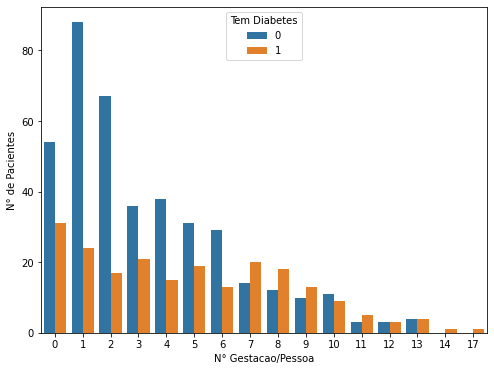

In [8]:
aux = strat_train_set[['Pregnancies','Outcome']].value_counts().sort_index().reset_index()
aux.columns = ['N° Gestacao/Pessoa', 'Tem Diabetes', 'N° de Pacientes']
plt.figure(figsize=(8, 6))
sns.barplot(aux, x='N° Gestacao/Pessoa', y='N° de Pacientes', hue='Tem Diabetes')
plt.show()

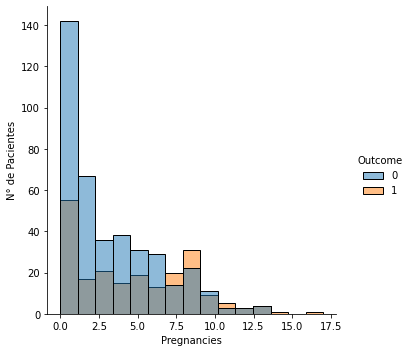

In [9]:
ax = sns.displot(strat_train_set, x="Pregnancies", hue='Outcome')
plt.xlabel("Pregnancies")
plt.ylabel('N° de Pacientes')
plt.show()

#### Glucose

Esta feature representa a "Concentração de glicose plasmática a 2 horas em um teste oral de tolerância à glicose".  
Neste teste é administrado uma quantidade X de glicose no paciente e após 2 horas é medido o valor de glicemia.  
Valores entre 140 e 200 mg/dL é considerado pré-diabetes e acima de 200mg/dL confirma o diagnóstico de diabetes.  
No gráfico abaixo, podemos observar tal feito, o número de casos sem diabetes com valores acima de 150mg/dL diminui considerávelmente.

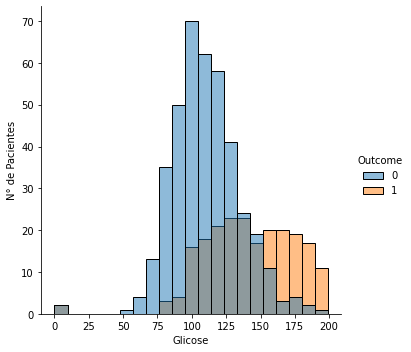

In [10]:
ax = sns.displot(strat_train_set, x="Glucose", hue='Outcome')
plt.xlabel("Glicose")
plt.ylabel('N° de Pacientes')
plt.show()

#### BloodPressure

Pressão arterial diastólica (mmHg)

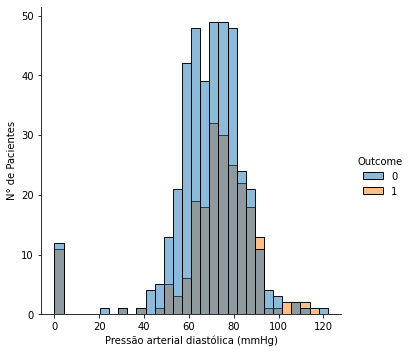

In [11]:
sns.displot(strat_train_set, x="BloodPressure", hue='Outcome')
plt.xlabel("Pressão arterial diastólica (mmHg)")
plt.ylabel('N° de Pacientes')
plt.show()

#### SkinThickness

Espessura da dobra cutânea do tríceps (mm)

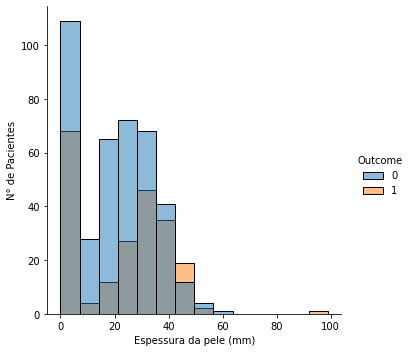

In [12]:
sns.displot(strat_train_set, x="SkinThickness", hue='Outcome')
plt.xlabel("Espessura da pele (mm)")
plt.ylabel('N° de Pacientes')
plt.show()

#### Insulin

Representa a "Insulina sérica de 2 horas (mu U/ml)".

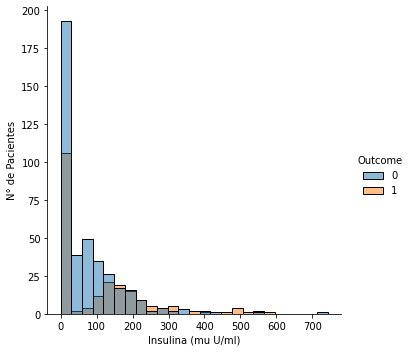

In [13]:
sns.displot(strat_train_set, x="Insulin", hue='Outcome')
plt.xlabel("Insulina (mu U/ml)")
plt.ylabel('N° de Pacientes')
plt.show()

#### BMI

Índice de massa corporal (peso em kg/(altura em m)^2)

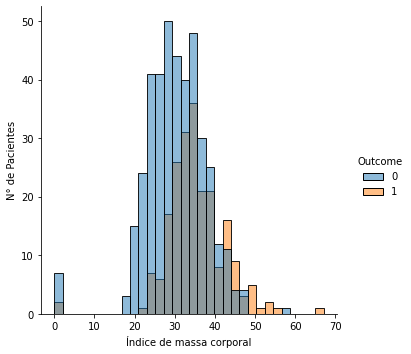

In [14]:
sns.displot(strat_train_set, x="BMI", hue='Outcome')
plt.xlabel("Índice de massa corporal")
plt.ylabel('N° de Pacientes')
plt.show()

#### DiabetesPedigreeFunction

Função hereditária do diabetes

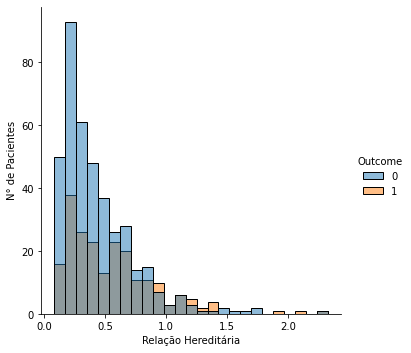

In [15]:
sns.displot(strat_train_set, x="DiabetesPedigreeFunction", hue='Outcome')
plt.xlabel("Relação Hereditária")
plt.ylabel('N° de Pacientes')
plt.show()

#### Age

Idade dos pacientes.

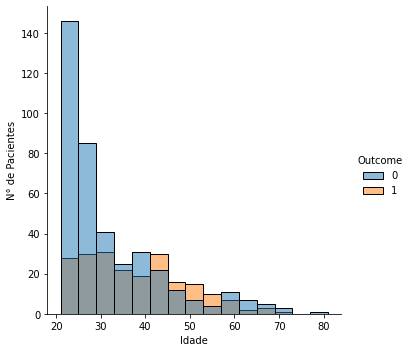

In [16]:
sns.displot(strat_train_set, x="Age", hue='Outcome')
plt.xlabel("Idade")
plt.ylabel('N° de Pacientes')
plt.show()

### Matriz de Correlação

Matriz de correlação das variáveis:
AxesSubplot(0.125,0.125;0.62x0.755)


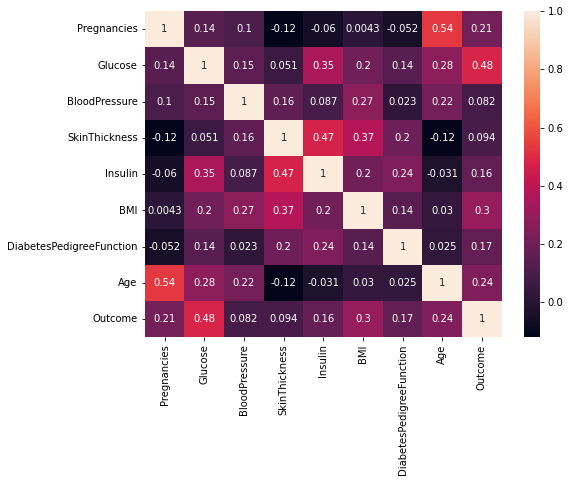

In [17]:
plt.figure(figsize=(8, 6))
print(f"Matriz de correlação das variáveis:\n{sns.heatmap(strat_train_set.corr(), annot=True)}")
plt.show()

### Feature Importance dos Dados Desbalanceados

<AxesSubplot:>

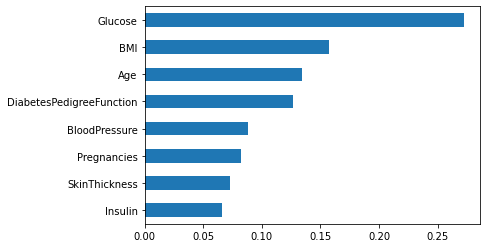

In [18]:
clf = RandomForestClassifier()
clf = clf.fit(strat_train_set.drop('Outcome', axis=1).values, strat_train_set.Outcome.values)
feature_importance = pd.Series(clf.feature_importances_, index=list(strat_train_set.drop('Outcome', axis=1).columns))
feature_importance = feature_importance.sort_values()
feature_importance.plot(kind='barh')

### Modelos

In [19]:
models = {
    'DecisionTreeClassifier': tree.DecisionTreeClassifier(), 
    'SGDClassifier': SGDClassifier(), 
    'RandomForestClassifier': RandomForestClassifier(), 
    'LogisticRegression': LogisticRegression(),
    'SVC': svm.SVC(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'MLPClassifier': MLPClassifier(),
    'Perceptron': Perceptron(),
    'GaussianProcessClassifier': GaussianProcessClassifier(),
    'BernoulliNB': BernoulliNB(),
    'GradientBoostingClassifier': GradientBoostingClassifier()
    }   

### Cross-validation sem Balanceamento dos Dados

In [20]:
count = 0
results = f'Modelo;Accuracy_{count};Mean Accuracy_{count};STD Accuracy_{count};F1_{count};Mean F1_{count};STD F1_{count};Precision_{count};Mean Precision_{count};STD Precision_{count};Recall_{count};Mean Recall_{count};STD Recall_{count}\n'
count += 1
for name, clf in models.items():
    X = strat_train_set.drop('Outcome', axis=1).values
    y = strat_train_set.Outcome.copy().values
    if name == 'LogisticRegression':
        X = preprocessing.StandardScaler().fit(X).transform(X)

    clf = clf.fit(X, y)
    cross = cross_validate(clf, X, y, scoring=["accuracy", "f1", "precision", "recall"], cv=3)
    results += f"{name};{list(cross['test_accuracy'])};{cross['test_accuracy'].mean()};{cross['test_accuracy'].std()}"
    results +=       f";{list(cross['test_f1'])};{cross['test_f1'].mean()};{cross['test_f1'].std()}"
    results +=       f";{list(cross['test_precision'])};{cross['test_precision'].mean()};{cross['test_precision'].std()}"
    results +=       f";{list(cross['test_recall'])};{cross['test_recall'].mean()};{cross['test_recall'].std()}\n"

with open('results.csv', 'w', encoding='utf-8') as w:
    w.write(results)

C:\Users\darla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:xlabel='Modelo'>

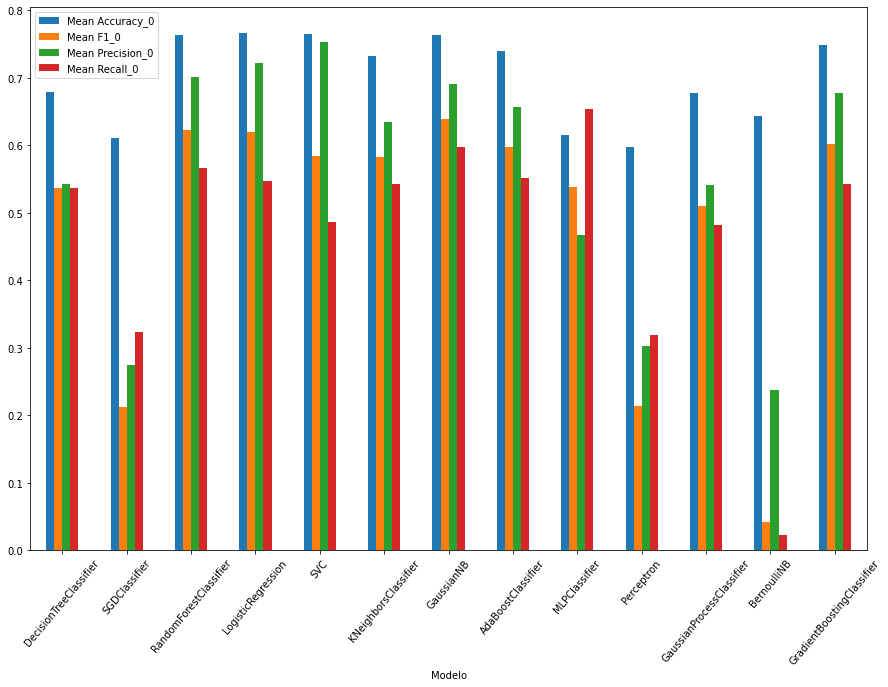

In [21]:
results = pd.read_csv('results.csv', delimiter=';')
results[['Modelo', 'Mean Accuracy_0', 'Mean F1_0', 'Mean Precision_0', 'Mean Recall_0']].plot(kind='bar', x='Modelo', figsize=(15,10), rot=50)

### Cross-validation Com Balanceamento dos Dados

In [22]:
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X, y)

In [23]:
results = f'Modelo;Accuracy_{count};Mean Accuracy_{count};STD Accuracy_{count};F1_{count};Mean F1_{count};STD F1_{count};Precision_{count};Mean Precision_{count};STD Precision_{count};Recall_{count};Mean Recall_{count};STD Recall_{count}\n'
count += 1
for name, clf in models.items():
    X = X_smote
    y = y_smote
    if name == 'LogisticRegression':
        X = preprocessing.StandardScaler().fit(X).transform(X)

    clf = clf.fit(X, y)
    cross = cross_validate(clf, X, y, scoring=["accuracy", "f1", "precision", "recall"], cv=3)
    results += f"{name};{list(cross['test_accuracy'])};{cross['test_accuracy'].mean()};{cross['test_accuracy'].std()}"
    results +=       f";{list(cross['test_f1'])};{cross['test_f1'].mean()};{cross['test_f1'].std()}"
    results +=       f";{list(cross['test_precision'])};{cross['test_precision'].mean()};{cross['test_precision'].std()}"
    results +=       f";{list(cross['test_recall'])};{cross['test_recall'].mean()};{cross['test_recall'].std()}\n"

with open('results_SMOTE.csv', 'w', encoding='utf-8') as w:
    w.write(results)

C:\Users\darla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<AxesSubplot:xlabel='Modelo'>

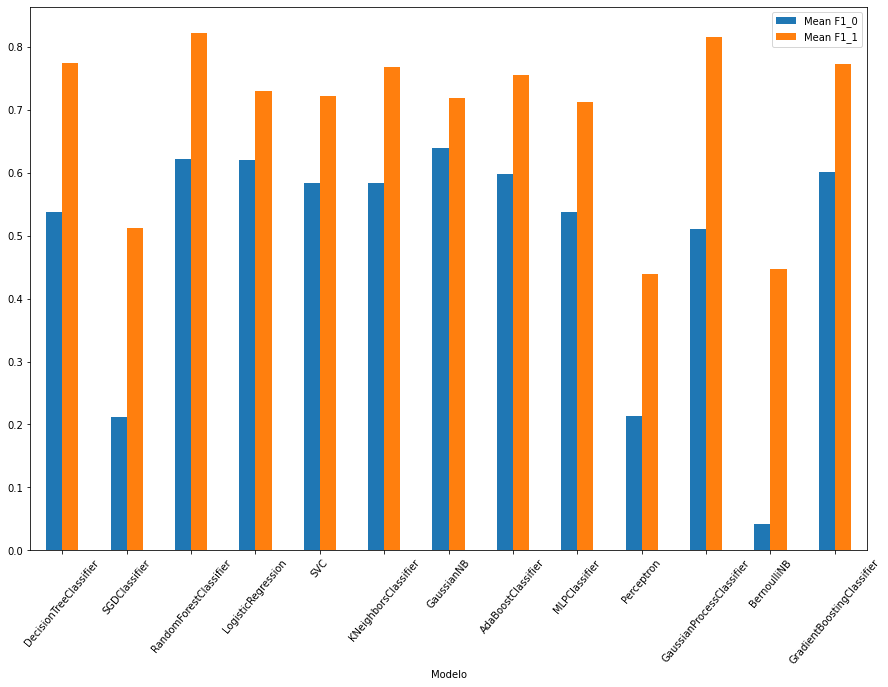

In [24]:
results = pd.read_csv('results.csv', delimiter=';')
results_SMOTE = pd.read_csv('results_SMOTE.csv', delimiter=';')
r = pd.merge(results, results_SMOTE, how='left', on='Modelo')
r[['Modelo', 'Mean F1_0', 'Mean F1_1']].plot(kind='bar', x='Modelo', figsize=(15,10), rot=50)

Como pode ser observado, todos os modelos melhoram após balancear os dados.

In [25]:
X_smote_stand = preprocessing.StandardScaler().fit(X_smote).transform(X_smote)

In [26]:
results = f'Modelo;Accuracy_{count};Mean Accuracy_{count};STD Accuracy_{count};F1_{count};Mean F1_{count};STD F1_{count};Precision_{count};Mean Precision_{count};STD Precision_{count};Recall_{count};Mean Recall_{count};STD Recall_{count}\n'
count += 1
for name, clf in models.items():
    clf = clf.fit(X_smote_stand, y_smote)
    cross = cross_validate(clf, X_smote_stand, y_smote, scoring=["accuracy", "f1", "precision", "recall", "roc_auc"], cv=3)
    results += f"{name};{list(cross['test_accuracy'])};{cross['test_accuracy'].mean()};{cross['test_accuracy'].std()}"
    results +=       f";{list(cross['test_f1'])};{cross['test_f1'].mean()};{cross['test_f1'].std()}"
    results +=       f";{list(cross['test_precision'])};{cross['test_precision'].mean()};{cross['test_precision'].std()}"
    results +=       f";{list(cross['test_recall'])};{cross['test_recall'].mean()};{cross['test_recall'].std()}\n"

with open('results_SMOTE_STAND.csv', 'w', encoding='utf-8') as w:
    w.write(results)

C:\Users\darla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\darla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\darla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\darla\A

<AxesSubplot:xlabel='Modelo'>

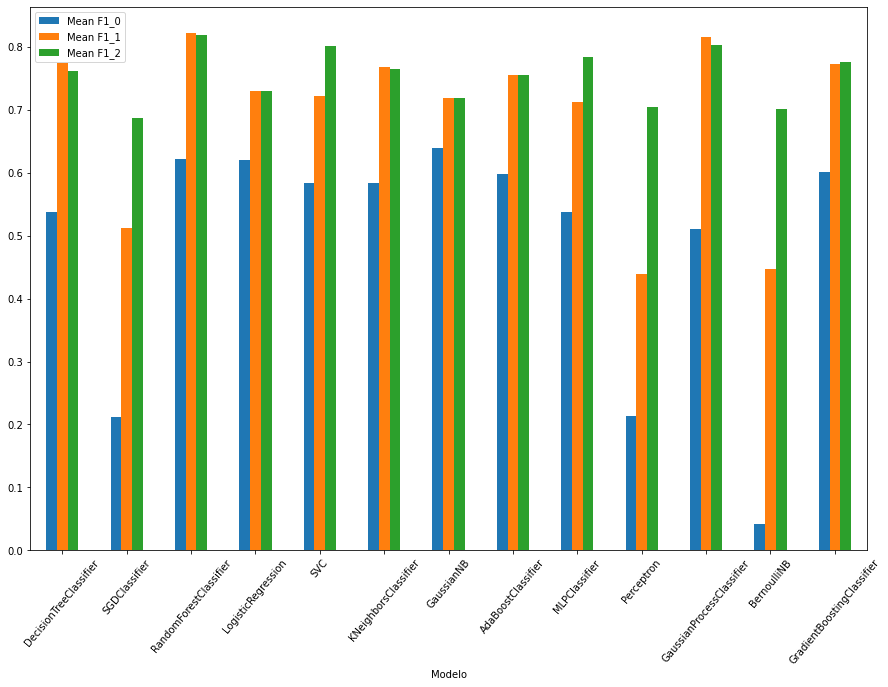

In [27]:
results = pd.read_csv('results.csv', delimiter=';')
results_SMOTE = pd.read_csv('results_SMOTE.csv', delimiter=';')
results_SMOTE_STAND = pd.read_csv('results_SMOTE_STAND.csv', delimiter=';')
r = pd.merge(results, results_SMOTE, how='left', on='Modelo')
r = pd.merge(r, results_SMOTE_STAND, how='left', on='Modelo')
r[['Modelo', 'Mean F1_0', 'Mean F1_1', 'Mean F1_2']].plot(kind='bar', x='Modelo', figsize=(15,10), rot=50)

Como podemos analisar acima, a maioria dos modelos apresentaram uma melhora após aplicar o [Standard Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)

### Predição do Modelo

In [28]:
models = {
    'RandomForestClassifier': RandomForestClassifier(), 
    'SVC': svm.SVC(),
    'GaussianProcessClassifier': GaussianProcessClassifier(),
}   

In [29]:
X_test = strat_test_set.drop('Outcome', axis=1).values
y_test = strat_test_set.Outcome.copy().values

In [30]:
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

In [31]:
sm = SMOTE(random_state=42)
X_test_smote, y_test_smote = sm.fit_resample(X_test, y_test)

In [32]:

results = f'Modelo;F1\n'
for name, clf in models.items():
    clf = clf.fit(X_smote_stand, y_smote)
    y_pred = cross_val_predict(clf, X_test_smote, y_test_smote, cv=3)
    results += f'{name};{f1_score(y_true=y_test_smote, y_pred=y_pred)}\n'

with open('results_predict.csv', 'w', encoding='utf-8') as w:
    w.write(results)

<AxesSubplot:xlabel='Modelo'>

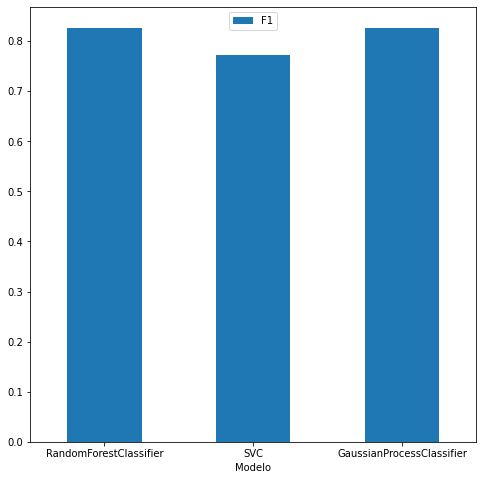

In [33]:
results = pd.read_csv('results_predict.csv', delimiter=';')
results.plot(kind='bar', x='Modelo', figsize=(8,8), rot=0)